## Постановка задачи
<b>Цель:</b> На основе данных из анализа крови и опросника пациента определить болен ли пациент диабетом второго типа или нет

<b>Задача:</b> разработать и обучить модель машинного обучения предсказывать наличия диабета у пациентов на основе предоставленных медицинских данных.

In [1]:
!pip install catboost -q
!pip install shap -q
!pip install phik -q
!pip install lightgbm -q

import pandas as pd 
import matplotlib.pyplot as plt 
import phik
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV

from sklearn.metrics import f1_score, confusion_matrix, multilabel_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

RANDOM_STATE=654321
TEST_SIZE=0.3

In [2]:
# Подавление предупреждений о сходимости
import warnings
from sklearn.exceptions import ConvergenceWarning
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=ConvergenceWarning)

In [3]:
df = pd.read_excel(r'C:\Users\ZeleninAD\Desktop\datasets/diabetes_ds.xlsx')
df.head()

,Номер,Перенес/ не перенес КВИ,Возраст,Пол,"Рост, см","Вес, кг",ИМТ 2 (ФОРМУЛА EXCEL),Эритроциты,Гемоглобин,Цветовой показатель,...,ИБС. ПИКС,ИБС. ПИКС (ЕСТЬ\НЕТ),"АГ, стадия",АГ (ЕСТЬ\НЕТ),"АГ, степень","АГ, риск","ХСН, стадии","ХСН, ФК","ХСН по фракции выброса, %",Сахарный диабет (ЕСТЬ\НЕТ)
0,390.0,1.0,68.0,2.0,158.0,86.0,34.449607,5.33,163.0,0.0,...,1.0,1.0,3.0,1.0,3.0,4.0,2.0,2.0,0,1.0
1,337.0,1.0,54.0,1.0,180.0,119.0,36.728395,5.01,130.0,0.0,...,1.0,1.0,3.0,1.0,3.0,4.0,2.0,3.0,35,1.0
2,160.0,1.0,68.0,1.0,174.0,110.0,36.332409,NaN,161.0,0.0,...,1.0,1.0,3.0,1.0,3.0,4.0,3.0,3.0,35,1.0
3,166.0,1.0,67.0,1.0,189.0,110.0,30.794211,4.47,134.0,0.0,...,1.0,1.0,3.0,1.0,3.0,4.0,3.0,3.0,0,1.0
4,439.0,1.0,60.0,1.0,178.0,115.0,36.295922,5.44,166.0,0.0,...,1.0,1.0,3.0,1.0,3.0,4.0,2.0,3.0,0,1.0


In [4]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [5]:
df_drop = df.copy()

In [6]:
df_drop = df_drop.drop(columns = df_drop.loc[:,df_drop.isna().sum() > 100].columns)

In [7]:
df_drop = df_drop.drop(columns = ['гидрохлортиазид', 'фуросемид', 'торасемид', 'спиронолактон', 'метформин', 'дапаглифлозин'])

In [8]:
df_drop.columns

Index(['номер', 'перенес/_не_перенес_кви', 'возраст', 'пол', 'рост,_см',
       'вес,_кг', 'имт_2_(формула_excel)', 'эритроциты', 'гемоглобин',
       'цветовой_показатель', 'лейкоциты', 'лимфоциты%_',
       'лимфоциты,_абс_(расчет_по_формуле)', 'тромбоциты', 'соэ', 'холестерин',
       'лпнп', 'лпвп', 'индекс_атерогенности_2_(формула_excel)', 'глюкоза',
       'алт', 'аст', 'натрийуретический_пептид', 'креатинин,_мкмоль/л',
       'скф_ckd-epi_(расчет_по_общей_формуле)', 'фавипиравир', 'молнупиравир',
       'валсартан', 'телмисартан', 'лозартан', 'кандесартан',
       'изосорбида_динитрат', 'периндоприл', 'рамиприл', 'эналаприл',
       'лизиноприл', 'бисопролол', 'карведилол', 'атенолол', 'верапамил',
       'дилтиазем', 'леркамен', 'амлодипин', 'дигоксин', 'ивабрадин',
       'гиполипидемические_препараты_(статины)', 'антикоагулянты,_препарат',
       'триметазидин', 'степени_ожирения_по_имт', 'ожирение_(есть\нет)',
       'bpb_голеней', 'bpb_голеней_(есть/нет)', 'тромбоэмболическ

In [9]:
columns = (['id', 'had_coronovirus', 'age', 'sex', 'height', 'weight', 'bmi', 'rbc', 'hemoglobin', 'bci', 'leukocytes', 'lymphocytes_%', 'lymphocytes_abs', 'platelets', 'esr',
                    'cholesterol', 'lpnl', 'hdl', 'atherogenic_index', 'glucose', 'alt', 'ast', 'nt_probpn', 'creatinin', 'ckd-epi', 'has_taken_favipiravir', 'has_taken_molnupiravir',
            'has_taken_valsartan', 'has_taken_telmicartan', 'has_taken_lozartan', 'has__taken_kandesartan', 'has_taken_isosorbide_dinitrate', 'has_taken_perindopril', 'has_taken_rampiril', 'has_taken_enalapril',
            'has_taken_lisinopril', 'has_taken_bisoprolol', 'has_taken_karvedilol', 'has_taken_atenolol', 'has_taken_verapamil', 'has_taken_diltiazem', 'has_taken_lercamen', 'has_taken_amlodipin',
            'has_taken_digocsin','has_taken_ivabradine', 'has_taken_statins', 'has_taken_anticoagulants', 'has_taken_trimetazidin', 'degree_of_obesity', 'has_obesity', 'bpb_shins', 'has_bpb_shins', 'has_thromboembolic_syndrome', 'has_congenital_heart_disease',
            'has_nafld', 'has_hypertrophy_miocard', 'has_hiss_blocade', 'extend_qt_interval', 'av_blocade','kidney_disease', 'kidney_disease(skf)', 'has_kidney_disease', 'atrial_fibrillation', 'has_atrial_fibrillation', 'has_ablation', 'coronary_bypass',
            'ba', 'has_ba', 'copd', 'has_copd', 'ci_stenocardia', 'has_ci_stenocardia','post-infarction_cardiosclerosis', 'has_post-infarction_cardiosclerosis', 'ah_step', 'has_ag', 'ag_degree', 'ag_risk', 'chf_step', 'chf_fc', 'chf_fc_%', 'has_diabetes'])

df_drop.columns = columns
df_drop.index = df_drop.id
df_drop = df_drop.drop(columns = ['id'])
df_drop = df_drop.drop(columns = df_drop.columns[8])

In [10]:
# отбросим записи с пропусками в целевом признаке
df_drop = df_drop[df_drop.has_diabetes.isna() != True]

In [11]:
# заменить пограничные значения в большую сторону
df_drop.loc[df_drop['has_hiss_blocade'] == '1-2', 'has_hiss_blocade'] = 2
df_drop['has_hiss_blocade'].unique()

# заменить пограничные и текстовые значения
df_drop.loc[df_drop['av_blocade'] == '2-3', 'av_blocade'] = 3
df_drop.loc[df_drop['av_blocade'] == '1-2', 'av_blocade'] = 2
df_drop.loc[df_drop['av_blocade'] == 'полная', 'av_blocade'] = 4 # заменим 'полная' на еще одну категорию - 4

df_drop.loc[df_drop['bpb_shins'] == '2-3', 'bpb_shins'] = 3

# заменить пограничные значения
df_drop.loc[df_drop['kidney_disease'] == 'с3а-с3б', 'kidney_disease'] = 'с3б'
df_drop.loc[df_drop['kidney_disease'] == 'с2-с3', 'kidney_disease'] = 'с3'
df_drop.loc[df_drop['kidney_disease'] == 'с1 а3', 'kidney_disease'] = 'c1a3'

df_drop[df_drop['kidney_disease(skf)'].isnull()][['age', 'sex', 'creatinin']] # без 'Креатинин, мкмоль/л' расчитать ХБП не получится

# С2 был заменен исходя из сочетаний ХСН ФК и ХСН стадии
df_drop['chf_fc_%'] = df_drop['chf_fc_%'].astype('str')
df_drop.loc[df_drop['chf_fc_%'] == 'с2','chf_fc_%'] = 20

# заменим пограничные значения на средние для каждой записи

df_drop.loc[df_drop['chf_fc_%'] == '24-25','chf_fc_%'] = 25
df_drop.loc[df_drop['chf_fc_%'] == '22-25','chf_fc_%'] = 24
df_drop.loc[df_drop['chf_fc_%'] == '40-45','chf_fc_%'] = 43
df_drop.loc[df_drop['chf_fc_%'] == '32-36','chf_fc_%'] = 34
df_drop.loc[df_drop['chf_fc_%'] == '20-25','chf_fc_%'] = 23
df_drop.loc[df_drop['chf_fc_%'] == '39-40','chf_fc_%'] = 40
df_drop.loc[df_drop['chf_fc_%'] == '15-20','chf_fc_%'] = 18
df_drop.loc[df_drop['chf_fc_%'] == '34-35','chf_fc_%'] = 35
df_drop.loc[df_drop['chf_fc_%'] == '30-31','chf_fc_%'] = 31
df_drop.loc[df_drop['chf_fc_%'] == '28-30','chf_fc_%'] = 29
df_drop.loc[df_drop['chf_fc_%'] == '42-43','chf_fc_%'] = 43
df_drop.loc[df_drop['chf_fc_%'] == '36-38','chf_fc_%'] = 37
df_drop.loc[df_drop['chf_fc_%'] == '30-32','chf_fc_%'] = 31
df_drop.loc[df_drop['chf_fc_%'] == '32-33','chf_fc_%'] = 33
df_drop.loc[df_drop['chf_fc_%'] == '30-35','chf_fc_%'] = 35
df_drop.loc[df_drop['chf_fc_%'] == '34-36','chf_fc_%'] = 35
df_drop.loc[df_drop['chf_fc_%'] == '30-35','chf_fc_%'] = 35
df_drop.loc[df_drop['chf_fc_%'] == '40-41','chf_fc_%'] = 41
df_drop.loc[df_drop['chf_fc_%'] == '33-48','chf_fc_%'] = 36
df_drop.loc[df_drop['chf_fc_%'] == '33-35','chf_fc_%'] = 34
df_drop.loc[df_drop['chf_fc_%'] == '46-48','chf_fc_%'] = 47
df_drop.loc[df_drop['chf_fc_%'] == '38-40','chf_fc_%'] = 39
df_drop.loc[df_drop['chf_fc_%'] == '35-37','chf_fc_%'] = 36
df_drop.loc[df_drop['chf_fc_%'] == '21-25','chf_fc_%'] = 23
df_drop.loc[df_drop['chf_fc_%'] == '46-48','chf_fc_%'] = 47
df_drop.loc[df_drop['chf_fc_%'] == '24-26','chf_fc_%'] = 25
df_drop.loc[df_drop['chf_fc_%'] == '33-52','chf_fc_%'] = 41
df_drop.loc[df_drop['chf_fc_%'] == '37-47','chf_fc_%'] = 42
df_drop.loc[df_drop['chf_fc_%'] == '23-25','chf_fc_%'] = 24
df_drop.loc[df_drop['chf_fc_%'] == '55-56','chf_fc_%'] = 56
df_drop.loc[df_drop['chf_fc_%'] == '20-32','chf_fc_%'] = 27
df_drop.loc[df_drop['chf_fc_%'] == '28.9','chf_fc_%'] = 29
df_drop.loc[df_drop['chf_fc_%'] == '25.9','chf_fc_%'] = 26
df_drop.loc[df_drop['chf_fc_%'] == '43.4','chf_fc_%'] = 44
df_drop.loc[df_drop['chf_fc_%'] == '18-20','chf_fc_%'] = 19

# заменить значения <40% - низкая, 40-49% - умеренно низкая, >50% - сохранненная фракция
df_drop['chf_fc_%'] = df_drop['chf_fc_%'].astype('float')
cat = []
for value in df_drop['chf_fc_%']:
    if value <=40:
        cat.append('низкая')
    elif value >40 and value <=49:
        cat.append('умеренно низкая')
    else:
        cat.append('сохранненная')
df_drop['chf_fc_%'] = cat

print(df_drop['chf_fc_%'].unique())
print()
print(df_drop['kidney_disease'].unique())
print()
print(df_drop['av_blocade'].unique())

['низкая' 'умеренно низкая' 'сохранненная']

[0 'с3б' 'с3' 'с2' 'с3а' '2а' 'с4' 'с1' '2са1' 'c1a3']

[0 1 3 2 4]


In [12]:
df_drop = df_drop[df_drop['has_obesity'] <2]

In [13]:
for el in df_drop.columns:
    print(el, df_drop[el].unique())

had_coronovirus [1. 2.]
age [68. 54. 67. 60. 62. 64. 65. 69. 66. 49. 70. 53. 58. 83. 63. 56. 45. 59.
 61. 57. 71. 52. 48. 55. 50. nan 44. 51. 46. 35. 41. 47.]
sex [2. 1.]
height [158. 180. 174. 189. 178. 185. 168. 183. 176. 165. 173. 169. 175. 170.
 187. 182. 150. 190. 172. 164. 167. 160. 177. 171. 163. 162. 188. 181.
 161. 184. 186. 152. 192. 157. 179. 166. 197. 194. 156. 154. 137. 159.]
weight [ 86.  119.  110.  115.  140.   89.  103.  111.   88.   80.   73.   78.
  83.   84.   87.   82.  105.   85.   91.  170.  124.   74.  112.   98.
 114.   59.   64.   72.   63.   90.   75.   94.  135.   97.  154.   93.
 120.  108.  125.   96.  101.  138.  100.   92.   95.  106.   99.  122.
 102.  109.   71.   79.   70.   76.   81.   77.   65.  107.  132.   67.
  57.  104.   60.  118.  130.  160.   56.  184.  113.   68.   50.  141.
  48.  121.  145.  168.  147.  111.5  62.   86.5  61.  155.   54.   69.
 139.   58. ]
bmi [34.44960743 36.72839506 36.33240851 30.79421069 36.29592223 40.90577064
 31.53

In [14]:
df_drop.info() # не числовые kidney_disease / chf_fc_%

<class 'pandas.core.frame.DataFrame'>
Index: 477 entries, 390.0 to 345.0
Data columns (total 80 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   had_coronovirus                      477 non-null    float64
 1   age                                  476 non-null    float64
 2   sex                                  477 non-null    float64
 3   height                               477 non-null    float64
 4   weight                               477 non-null    float64
 5   bmi                                  477 non-null    float64
 6   rbc                                  474 non-null    float64
 7   hemoglobin                           477 non-null    float64
 8   leukocytes                           476 non-null    float64
 9   lymphocytes_%                        476 non-null    float64
 10  lymphocytes_abs                      475 non-null    float64
 11  platelets                      

In [15]:
train,test = train_test_split(df_drop, test_size = TEST_SIZE, random_state = RANDOM_STATE, stratify=df_drop['has_diabetes'])

In [16]:
print(train.shape)
print(test.shape)

(333, 80)
(144, 80)


In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 333 entries, 143.0 to 135.0
Data columns (total 80 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   had_coronovirus                      333 non-null    float64
 1   age                                  333 non-null    float64
 2   sex                                  333 non-null    float64
 3   height                               333 non-null    float64
 4   weight                               333 non-null    float64
 5   bmi                                  333 non-null    float64
 6   rbc                                  331 non-null    float64
 7   hemoglobin                           333 non-null    float64
 8   leukocytes                           333 non-null    float64
 9   lymphocytes_%                        333 non-null    float64
 10  lymphocytes_abs                      333 non-null    float64
 11  platelets                      

In [18]:
# удалим пропуски, которые не получится восстановить
train = train[~train['degree_of_obesity'].isnull()]
train = train[~train['has_bpb_shins'].isnull()]
train = train[~train['has_thromboembolic_syndrome'].isnull()]
train = train[~train['has_nafld'].isnull()]
train = train[~train['has_hypertrophy_miocard'].isnull()]
train = train[~train['kidney_disease(skf)'].isnull()]
train = train[~train['atrial_fibrillation'].isnull()]
train = train[~train['has_diabetes'].isnull()]

In [19]:
train.isnull().sum().sort_values(ascending=False)[:20]

ast                         49
alt                         41
nt_probpn                   32
atherogenic_index           32
esr                         30
hdl                         29
lpnl                        24
glucose                     18
has_taken_anticoagulants    17
cholesterol                 16
platelets                    3
rbc                          2
has_taken_telmicartan        1
has_taken_lozartan           1
has__taken_kandesartan       1
has_atrial_fibrillation      0
atrial_fibrillation          0
has_kidney_disease           0
kidney_disease               0
kidney_disease(skf)          0
dtype: int64

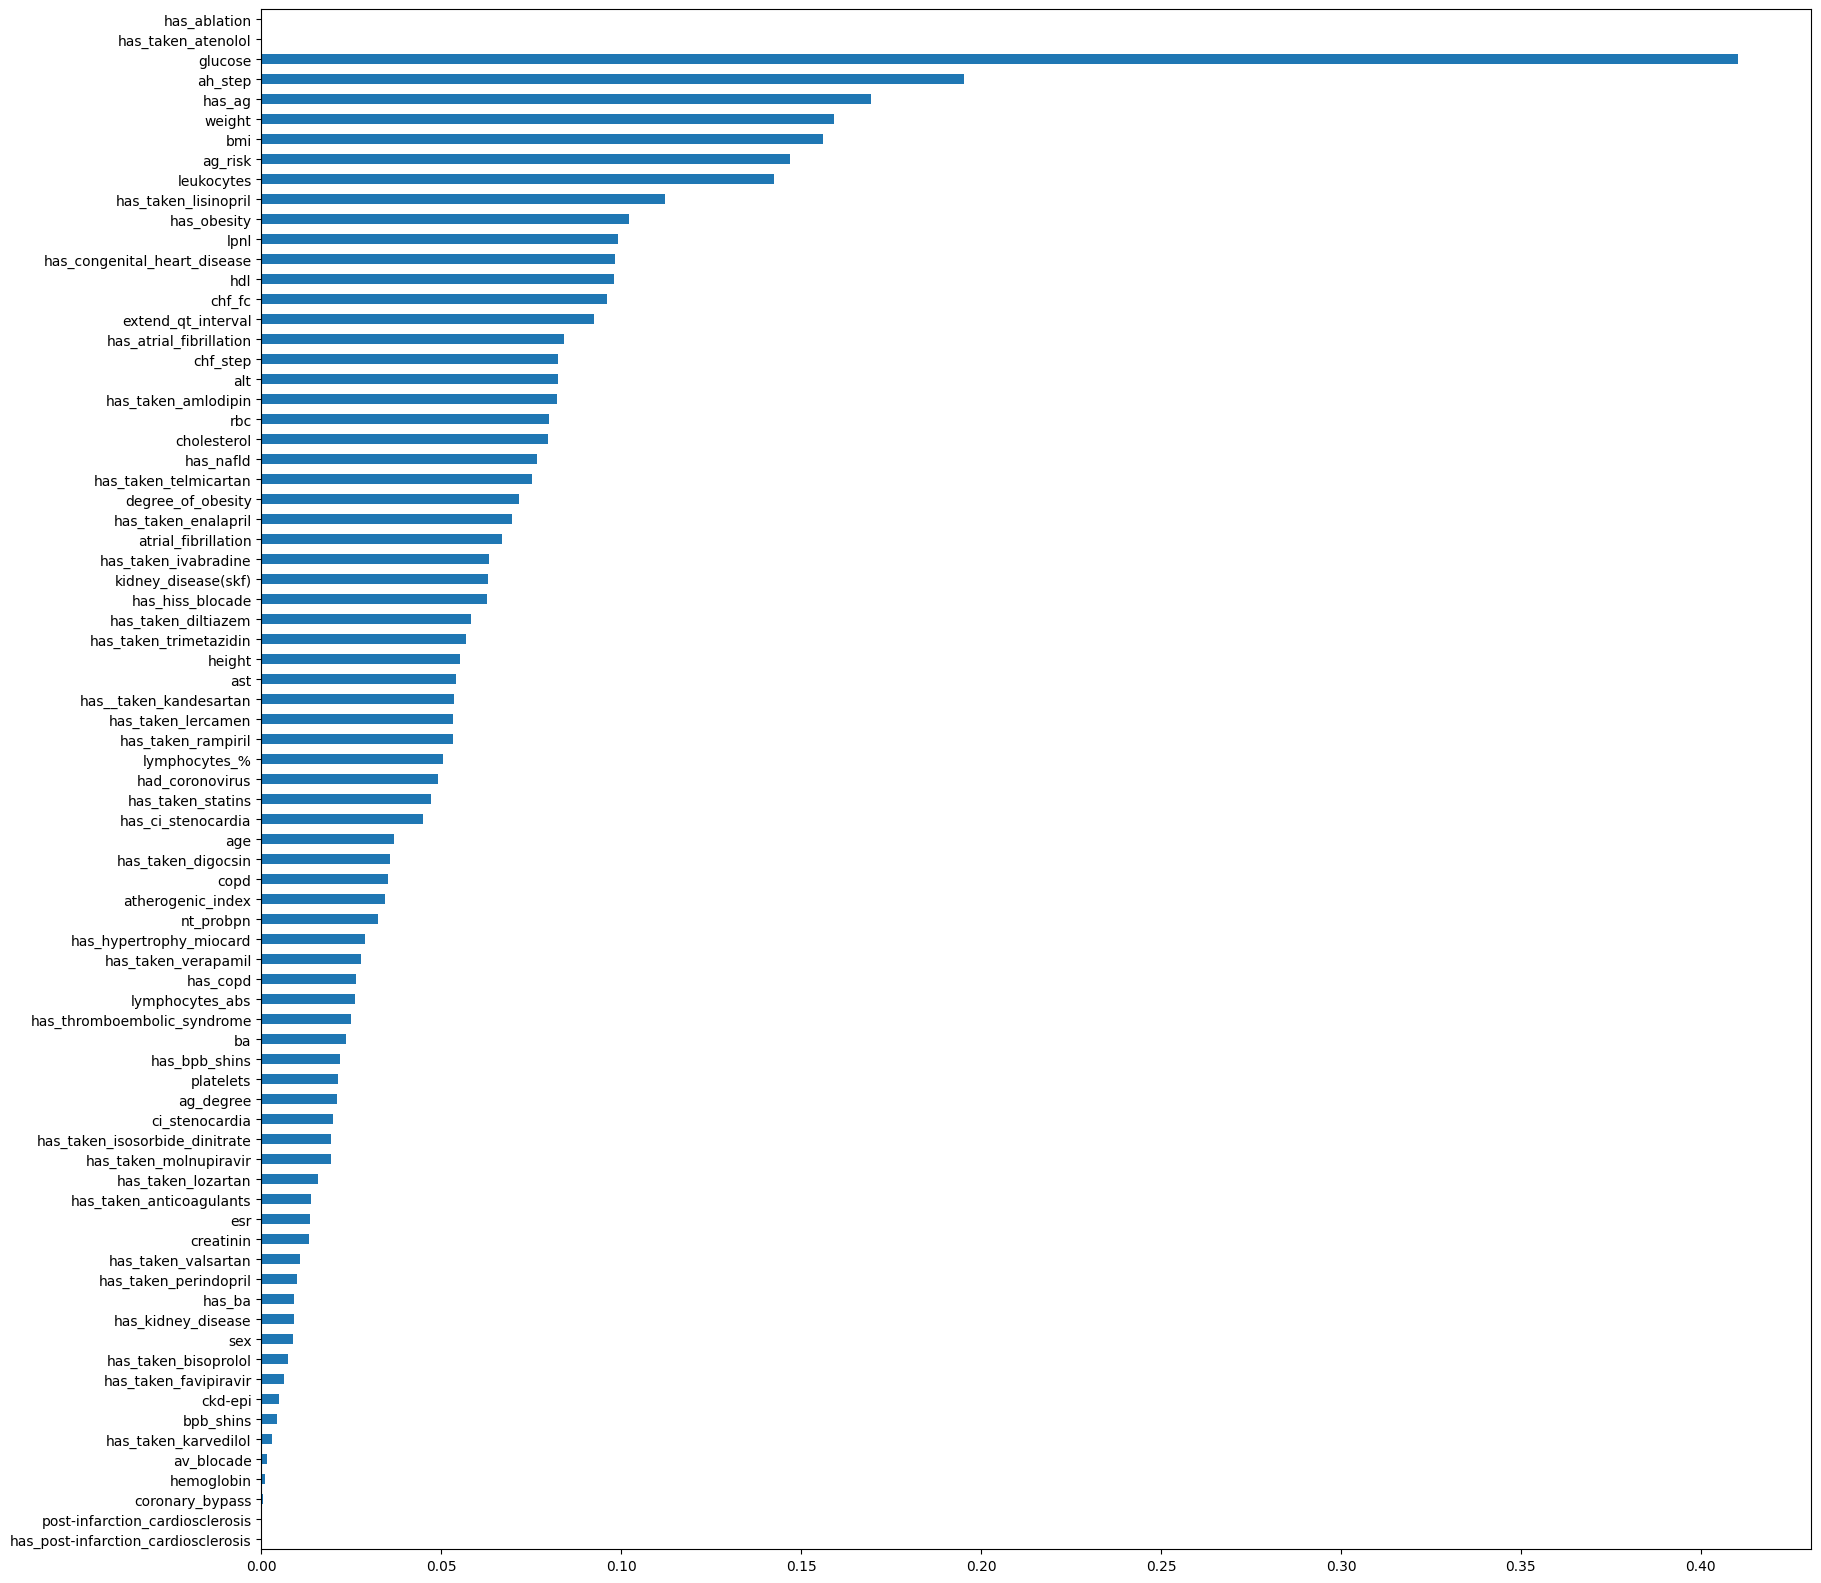

In [20]:
corr = train.drop(columns=['kidney_disease', 'chf_fc_%']).corr()
ax = plt.subplots(figsize=(20,20))
ax = abs(corr['has_diabetes'].drop('has_diabetes')).sort_values(ascending= True).plot(kind = 'barh');
plt.show()

## Разделение выборки и моделирование

In [21]:
X_train = train.drop(columns='has_diabetes')
y_train = train['has_diabetes']
X_test = test.drop(columns='has_diabetes')
y_test = test['has_diabetes']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((323, 79), (323,), (144, 79), (144,))

In [22]:
numeric_features = X_train.drop(columns=['kidney_disease', 'chf_fc_%'], axis=1).columns
categorial_features = ['kidney_disease', 'chf_fc_%']
X_train[numeric_features] = X_train[numeric_features].astype(float)
X_train[categorial_features] = X_train[categorial_features].astype(str)

In [23]:
# Предобработка числовых признаков
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median", missing_values=np.nan)), 
           ("scaler", StandardScaler())
          ]
)

# Предобработка категориальных признаков
categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy='most_frequent')),
           ("encoder", OneHotEncoder(handle_unknown="ignore"))
          ]
)

# Преобразование признаков
data_preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorial_features)
    ])

In [24]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid1 = [
    
    # словарь для модели DecisionTreeClassifier
    {'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
     'models__max_depth': range(2,5),
     'models__max_features': range(2,5),
     'preprocessor__num': [StandardScaler(), 'passthrough']},
    
    # словарь для модели LogisticRegression
    {'models': [LogisticRegression(
        random_state=RANDOM_STATE, 
        solver='liblinear', 
        penalty='l1')],
     'models__C': range(1,5),
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']},

    # словарь для SCV
    {'models': [SVC(probability=True)],
     'models__C':[0.1,1,10],
     'models__kernel':['linear'],
     'models__degree':[1,3,4],
     'models__gamma':[1,0.1,0.01],
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']},

    # словарь для CatBoostClassifiers
    {'models': [CatBoostClassifier(random_state=RANDOM_STATE, loss_function ="CrossEntropy")],
     'models__iterations': range(1000, 2000),  
     'models__learning_rate': [0.1,0.3,0.5],
     'models__depth': range(2,10),
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}
]

rs1 = RandomizedSearchCV(
    pipe_final, 
    param_grid1, 
    cv=5, 
    scoring='f1_macro',
    n_jobs=-1,
    random_state=RANDOM_STATE
)
rs1.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', rs1.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', rs1.best_score_)

0:	learn: 0.6579768	total: 147ms	remaining: 3m 55s
1:	learn: 0.6353223	total: 155ms	remaining: 2m 3s
2:	learn: 0.6112838	total: 163ms	remaining: 1m 26s
3:	learn: 0.5746977	total: 171ms	remaining: 1m 8s
4:	learn: 0.5437127	total: 179ms	remaining: 57s
5:	learn: 0.5148323	total: 187ms	remaining: 49.5s
6:	learn: 0.4967094	total: 194ms	remaining: 44s
7:	learn: 0.4803935	total: 200ms	remaining: 39.8s
8:	learn: 0.4640895	total: 208ms	remaining: 36.7s
9:	learn: 0.4462317	total: 216ms	remaining: 34.3s
10:	learn: 0.4345796	total: 224ms	remaining: 32.3s
11:	learn: 0.4210042	total: 231ms	remaining: 30.6s
12:	learn: 0.4092094	total: 240ms	remaining: 29.2s
13:	learn: 0.3922178	total: 248ms	remaining: 28s
14:	learn: 0.3796466	total: 256ms	remaining: 27s
15:	learn: 0.3643413	total: 264ms	remaining: 26.1s
16:	learn: 0.3523754	total: 272ms	remaining: 25.3s
17:	learn: 0.3418487	total: 281ms	remaining: 24.7s
18:	learn: 0.3309279	total: 290ms	remaining: 24.1s
19:	learn: 0.3224329	total: 299ms	remaining: 23

In [25]:
y_pred1 = rs1.best_estimator_.predict(X_test) 
print(f"Точность модали на тестовой выборке: {f1_score(y_test, y_pred1, average='macro')}")

Точность модали на тестовой выборке: 0.7002178649237474


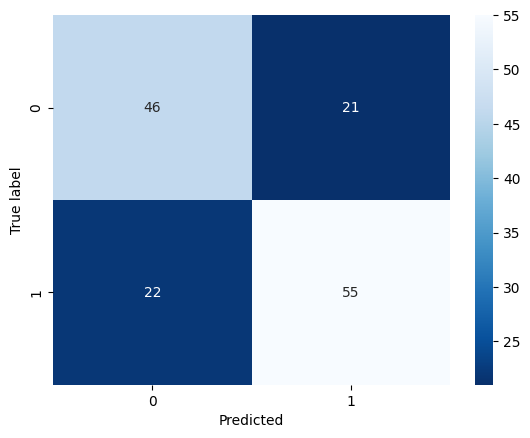

In [26]:
cm1 = confusion_matrix(y_test, y_pred1)
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted'); 

 99%|===================| 142/144 [00:13<00:00]        

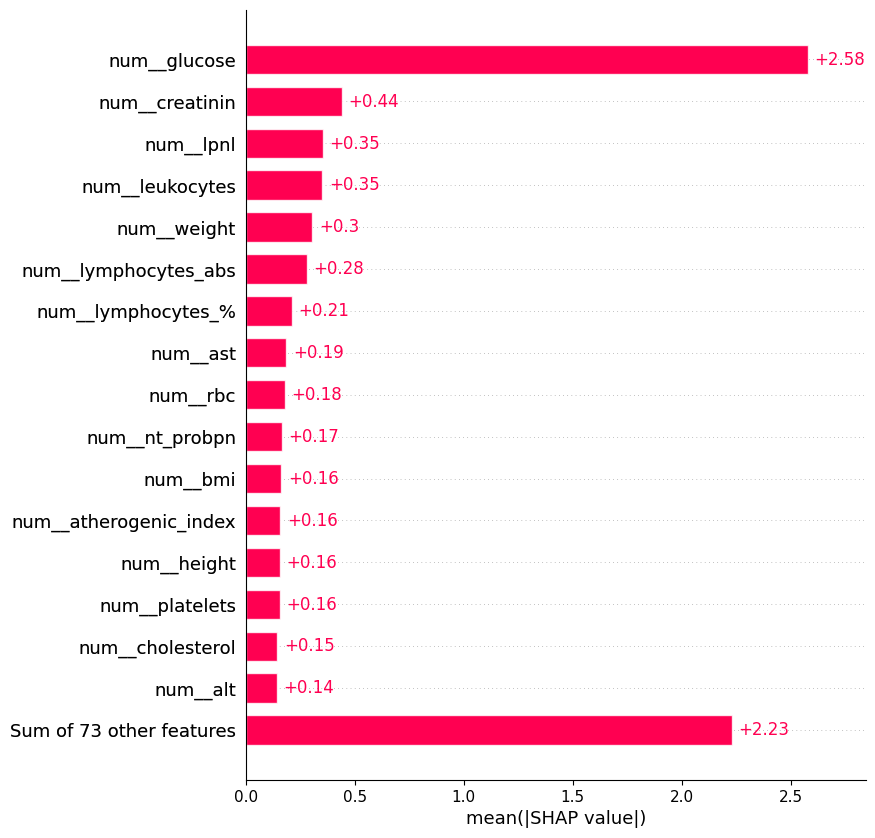

In [27]:
!pip install shap -q
import shap 

x_Train = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
explainer1 = shap.Explainer(rs1.best_estimator_.named_steps['models'], x_Train)
x_Test = pipe_final.named_steps['preprocessor'].transform(X_test)
features_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()
x_Test = pd.DataFrame(x_Test, columns=features_names)
shap_values1=explainer1(x_Test)

shap.plots.bar(shap_values1, max_display=17) 

In [28]:
from sklearn.ensemble import RandomForestClassifier

param_grid2 = [
    # словарь для LGBMClassifier
    {'models': [LGBMClassifier(random_state=RANDOM_STATE)],
     'models__learning_rate':[0.1,0.03,0.05],
     'models__num_leaves': range(15, 50),
     'models__max_depth': range(2, 10),
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']},
        
     # словарь для модели KNeighborsClassifier
    {'models': [KNeighborsClassifier()],
     'models__n_neighbors': range(2,5),
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']},

    # словарь для модели RandomForestClassifier
    {'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
     'models__max_depth': [None, 3, 5, 10],
     'moodels___n_estimators': [100, 200],
     'models__min_samples_leaf': [4, 15, 30, 60]}
]

rs2 = RandomizedSearchCV(
    pipe_final, 
    param_grid2, 
    cv=5, 
    scoring='f1_macro',
    n_jobs=-1,
    random_state=RANDOM_STATE
)
rs2.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', rs2.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', rs2.best_score_)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 169, number of negative: 154
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1804
[LightGBM] [Info] Number of data points in the train set: 323, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.523220 -> initscore=0.092946
[LightGBM] [Info] Start training from score 0.092946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

In [29]:
y_pred2 = rs2.best_estimator_.predict(X_test) 
print(f"Точность модали на тестовой выборке: {f1_score(y_test, y_pred2, average='macro')}")

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Точность модали на тестовой выборке: 0.7129382019740361


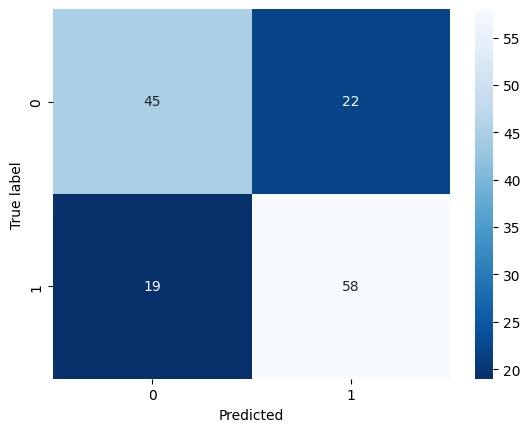

In [30]:
cm2 = confusion_matrix(y_test, y_pred2)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted'); 

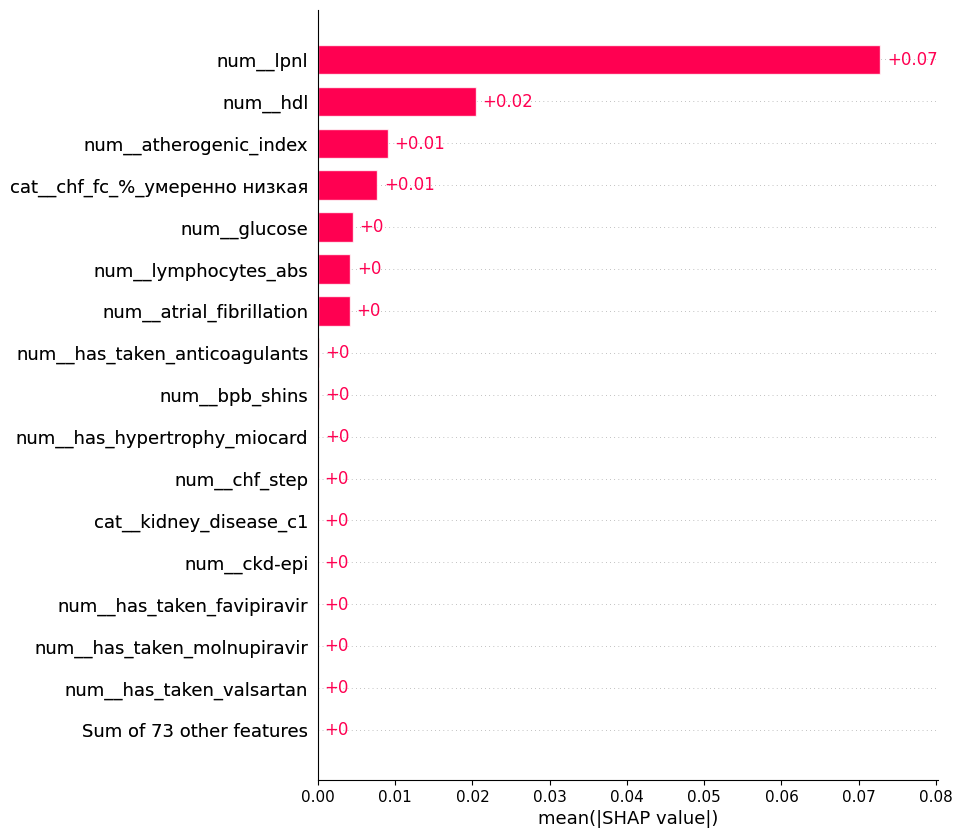

In [31]:
explainer2 = shap.Explainer(rs2.best_estimator_.named_steps['models'], x_Train)
shap_values2=explainer2(x_Test)
shap.plots.bar(shap_values2, max_display=17)  

## Вывод

Среди опробованных моделей:
 - DecisionTreeClassifier
 - LogisticRegression
 - SVC
 - CatBoostClassifier
 - LGBMClassifier
 - KNeighborsClassifier
 - RandomForestClassifier

    Лучшие результаты показали:
   
| модель                        |  train  |  test   |
| ----------------------------- | ------- | ------- |
| CatBoostClassifier            |  0.71   |   0.7   | 
| LGBMClassifier                |  0.71   |  0.71   |
